## Dataset: CESNET
#### Author: Jakub Čoček (xcocek00)

| Augmentations | Filters | Training | Validation | Fine-tuning | Testing |
|---------------|---------|----------|------------|----------------|---------|
| Change in Inter-Arrival Time (IAT) | none | CESNET | n/a | n/a | n/a |


In [27]:
# -- IMPORTS --

import os
os.chdir('/workplace/flowmind/')

import csv
import sys

# torch imports
import torch
import torch.nn as nn

# flowmind imports
from flowmind.contrastive import NTXentLoss

# livelossplot imports
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

# common imports
os.chdir('/workplace/xcocek00/common/')
from augmentations import augment_iat
os.chdir('/workplace/xcocek00/common/')
from dataloader import create_flowpic_dataloader
os.chdir('/workplace/xcocek00/common/')
from nn import CNN

# sets csv limit
csv.field_size_limit(sys.maxsize)

# sets the device to use gpu if available, if not, use cpu
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")


In [28]:
# -- DATA LOADERS for ucdavis --
# dataloaders yield tuple (flowpic1, flowpic2, label)
# using only 15 seconds of the flow

# 0 - debug prints are turned off
# 1 - debug prints are turned on
DEBUG = 0

# dataloader used for training
dl_train = create_flowpic_dataloader(
    dir_path="/workplace/data/long-export/tls-pstats100/tmp_balanced/train_all_timestamps.csv",    
    batch_size=32,
    meta_key="label",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    flow_transform_1=augment_iat,
    flow_transform_2=augment_iat,
    bidirectional = False,
)


if DEBUG:    
    print(type(dl_train))
    dim_val(dl_train)
    print_batch(dl_train, "training")
    print_batch(dl_class, "classification")
    debug_batch(dl_train)

In [29]:
# -- training loops--

def train(model, dataloader, optimizer, contrastive_loss_fn, log):
    '''
    Training loop

    Args:
        model: CNN model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        optimizer: chosen optimizer
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''

    model.train()
    total_loss = 0.0
    batches = 0

    # label not needed in -> _
    for flowpic1, flowpic2, _ in dataloader:
        flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

        optimizer.zero_grad()

        z1 = model(flowpic1)
        z2 = model(flowpic2)
        
        # contrastive loss
        loss = contrastive_loss_fn(z1, z2)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1
        
    total_loss /= batches
    log["loss"] = total_loss

    return total_loss


In [30]:
# -- traning CNN --

def train_cnn(cnn_model, dl_train, cnn_optimizer, contrastive_loss_fn, cnn_liveloss) -> None:
    # set params for early stopping
    patience = 3
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(30):
        log = {}
        train_loss = train(cnn_model, dl_train, cnn_optimizer, contrastive_loss_fn, log)

        cnn_liveloss.update(log)
        cnn_liveloss.send()

        if train_loss < best_loss:
            best_loss = train_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Stopping ... epoch ", epoch)
            break
    
    return 

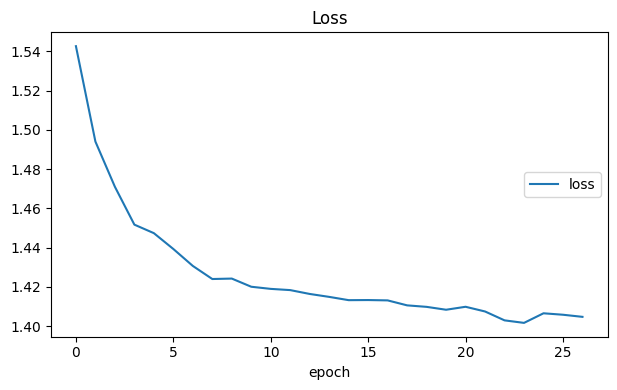

Stopping ... epoch  26
DONE


In [31]:
# -- CESNET dataset --

# loss functions
contrastive_loss_fn = NTXentLoss(temperature=0.07)
mlp_loss_fn = nn.CrossEntropyLoss()

# CNN
cnn_model = CNN().to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

# train cnn
_ = train_cnn(cnn_model, dl_train, cnn_optimizer, contrastive_loss_fn, cnn_liveloss)

# save model
torch.save(cnn_model.state_dict(), f"/workplace/xcocek00/models/cnn_model.pth")

print(f"DONE")